<div>
Olá, Jonathas!

Meu nome é Luiz. Fico feliz em revisar seu projeto. Ao longo do texto farei algumas observações sobre melhorias no código e também farei comentários sobre suas percepções sobre o assunto. Estarei aberto a feedbacks e discussões sobre o tema.

**Peço que mantenha e não altere os comentários que eu fizer por aqui para que possamos nos localizar posteriormente, ok?**

Mais uma coisa, vamos utilizar um código de cores para você entender o meu feedback no seu notebook. Funciona assim:

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Sucesso. Tudo foi feito corretamente.
</div>

<div class="alert alert-block alert-warning">
<b>Comentário do revisor: </b> <a class="tocSkip"></a>

Alerta não crítico, mas que pode ser corrigido para melhoria geral no seu código/análise.
</div>

<div class="alert alert-block alert-danger">

<b>Comentário do revisor: </b> <a class="tocSkip"></a>
    
Erro que precisa ser arrumado, caso contrário seu projeto **não** será aceito.
</div>

Você pode interagir comigo através dessa célula:
<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-danger">
<b> Comentário geral do revisor v1</b> <a class="tocSkip"></a>
    
Obrigado por enviar o seu projeto e pelo esforço de chegar até aqui. O seu projeto possui alguns pontos bem interessantes, dos quais eu destaco:
    
- Código bem simples e estruturado 
- Comentários sucintos e bem objetivos
- Análises bem detalhadas em cada etapa do projeto
    
Entretanto, deixei alguns comentários em alguns trechos que precisam de ajuste. Peço que trabalhe nesses pontos para avançarmos. 

<br>
    
Qualquer dúvida, pode contar comigo.   
    
    
**Até breve!**

</div>

# Análise de Teste A/B: Impacto da Mudança de Fonte no Funil de Compras

## Introdução

Este notebook analisa os dados de logs de um aplicativo móvel (`logs_exp_us.csv`) para avaliar o impacto de uma alteração de fonte em um teste A/B. O objetivo principal é determinar se a nova fonte (Grupo B) afeta o comportamento do usuário ao longo do funil de eventos principal, em comparação com os grupos de controle (Grupo A1 e Grupo A2) que utilizam a fonte antiga.

Os dados contêm informações sobre:
*   `event`: O nome do evento registrado (ex: `MainScreenAppear`, `PaymentScreenSuccessful`).
*   `id`: O identificador único do usuário.
*   `time`: O momento exato em que o evento ocorreu.
*   `group`: O grupo do experimento ao qual o usuário pertence (A1 e A2 são controles, B é o grupo de teste com a nova fonte).

A análise seguirá os seguintes passos:
1.  Carregamento e pré-processamento dos dados, incluindo conversão de tipos e mapeamento dos grupos.
2.  Análise exploratória dos dados (EDA) para entender a distribuição dos eventos, usuários, o período do experimento e a consistência dos dados.
3.  Construção e análise do funil de eventos principal (`MainScreenAppear` -> `OffersScreenAppear` -> `CartScreenAppear` -> `PaymentScreenSuccessful`) para identificar taxas de conversão e pontos de abandono.
4.  Realização de um teste A/A para verificar se os grupos de controle (A1 e A2) são estatisticamente semelhantes, validando a configuração do experimento.
5.  Realização de testes A/B (usando testes Z para proporções) para comparar o grupo de teste (B) com os grupos de controle (A1, A2 e combinado) em cada etapa do funil.
6.  Discussão sobre os níveis de significância e conclusões sobre o impacto da mudança de fonte.

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import plotly.express as px
import os

In [ ]:
local = r'C:\Users\jonat\Documents\GitHub\Sprints\sprint 11'
servidor = '/datasets'
caminho_arquivo = os.path.join(servidor, 'logs_exp_us.csv')

df = pd.read_csv(caminho_arquivo, sep='\t')
df.columns = ["event", "id", "time", 'group']
df.head(5)

,event,id,time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- [x] O conjunto de dados foi carregado corretamente usando o separador `\t`
- [ ] Aqui você precisa carregar os dados a partir do servidor da Tripleten em `/datasets/logs_exp_us.csv`
</div>

<div class="alert alert-block alert-info">
<b>Eu não fiz desta forma pois estou usando o VSCode para rodar da minha maquina. </b> <a class="tocSkip"></a>
</div>

# dados
- event — nome do evento
- id — identificador de usuário exclusivo
- time — hora do evento
- grupo — número do experimento: 246 e 247 são os grupos de controle, 248 é o grupo de teste

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   event   244126 non-null  object
 1   id      244126 non-null  int64 
 2   time    244126 non-null  int64 
 3   group   244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [158]:
# Conversão de tipos 
df['event'] = df['event'].astype('category')
df['time'] = pd.to_datetime(df['time'], unit='s')
mapping = {246: 'A1', 247: 'A2', 248: 'B'}
df['group'] = df['group'].map(lambda x: mapping.get(x, x)).astype('category')

# Exibindo resultado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   244126 non-null  category      
 1   id      244126 non-null  int64         
 2   time    244126 non-null  datetime64[ns]
 3   group   244126 non-null  category      
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 4.2 MB


In [159]:
df.isnull().any().to_dict()

{'event': False, 'id': False, 'time': False, 'group': False}

Não tem valores nulos.

<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- Os nomes das colunas foram convertidos para seguir o padrão `snake_case`
- A hora foi extraída a partir do timestamp
- Aqui você poderia analisar os valores nulos do conjunto de dados
</div>

# dados tratados
Agora o df de 7,5mb passou a ter 4,2mg. E fiz uma atualização na tabela group para que mostre uma string com os grupos especificos que nomei: 
- A1 = 246
- A2 = 247
- B = 248

In [160]:
df['data'] = pd.to_datetime(df['time']).dt.date
df

,event,id,time,group,data
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A2,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A1,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A1,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A1,2019-08-07


In [161]:
df['event'].unique()

['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Categories (5, object): ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

MainScreenAppear — Tela principal apareceu

PaymentScreenSuccessful — Pagamento realizado com sucesso

CartScreenAppear — Tela do carrinho apareceu

OffersScreenAppear — Tela de ofertas apareceu

Tutorial — Tutorial exibido

In [162]:
def verificar_valores_ausentes(df):
    ausentes = df.isnull().sum()
    return ausentes[ausentes > 0] if ausentes.any() else "Nenhum valor ausente encontrado."
resultado = verificar_valores_ausentes(df)
print(resultado)


Nenhum valor ausente encontrado.


In [163]:
df['event'].nunique()


5

São 5 eventos registrados

In [164]:
df['id'].nunique()

7551

Tem 7551 ids que representam essa quantidade de clientes.

In [165]:
df.groupby('id')['event'].count().mean()

32.33028737915508

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
  
As estatísticas dos usuários foram analisadas
</div>

A média de eventos por usuário é de 32.

In [166]:
print(f'A menor data é {df['data'].min()} e a maior data é {df['data'].max()} um total de {df['data'].max() - df['data'].min()} ')

A menor data é 2019-07-25 e a maior data é 2019-08-07 um total de 13 days, 0:00:00 


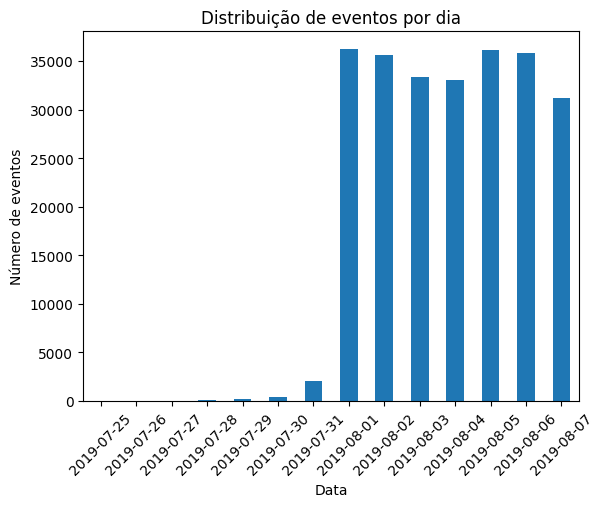

In [167]:
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

df['date'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuição de eventos por dia')
plt.xlabel('Data')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()


<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
   
- Aqui você precisa plotar a distribuição por data:
        - Exibir o período de cobertura dos dados
        - Identificar a partir de qual dia os dados começam a ficar completos (ver no gráfico acima)
        - Calcular o percentual de dados descartados ao filtrar o período em que os dados começaram a vir completos
- Aqui você precisa calcular o percentual também de dados que será descartado ao aplicar o filtro acima

</div>

<div class="alert alert-block alert-info">
<b>Feito logo a baixo.</b> <a class="tocSkip"></a>
</div>

Os dados começam a ter volume e consistencia a partir do dia 31/07

In [168]:
dfold = df
df = df[df['time'] >= '2019-07-31']
print(f'A menor data é {df['data'].min()} e a maior data é {df['data'].max()} um total de {df['data'].max() - df['data'].min()} ')

A menor data é 2019-07-31 e a maior data é 2019-08-07 um total de 7 days, 0:00:00 


In [169]:
linhas_perdidas = dfold.shape[0] - df.shape[0]
total_linhas = dfold.shape[0]
proporcao = linhas_perdidas / total_linhas

print(f"""{linhas_perdidas} linhas de {total_linhas} foram perdidas.
A proporção é de {proporcao:.2%}""")


797 linhas de 244126 foram perdidas.
A proporção é de 0.33%


<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Aqui precisamos de pequenos ajustes: não é possível que `0` linhas sejam perdidas, uma vez que você está filtrando os dados acima. Como sugestão, você pode calcular também o percentual de eventos que serão removidos. O resultado esperado é algo próximo de ~2%.
</div>

não foram muitos eventos e usuários. 

In [170]:
df.groupby('group')['id'].count()

C:\Users\jonat\AppData\Local\Temp\ipykernel_12488\1343537145.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('group')['id'].count()


group
A1    80045
A2    77811
B     85473
Name: id, dtype: int64

Tem bastantes usuários de todos os 3 grupos.

In [171]:
df['event'].value_counts()


event
MainScreenAppear           118681
OffersScreenAppear          46724
CartScreenAppear            42623
PaymentScreenSuccessful     34253
Tutorial                     1048
Name: count, dtype: int64

In [172]:
# Total de usuários únicos no dataset
total_usuarios = df['id'].nunique()

# Número de usuários únicos por evento
usuarios_por_evento = df.groupby('event')['id'].nunique().sort_values(ascending=False)

# Proporção de usuários por evento
proporcao_usuarios = usuarios_por_evento / total_usuarios

# Juntando em um DataFrame com porcentagem formatada
resultado = pd.DataFrame({
    'usuarios_unicos': usuarios_por_evento,
    'proporcao (%)': proporcao_usuarios.map(lambda x: f'{x:.1%}')
})

print(resultado)


                         usuarios_unicos proporcao (%)
event                                                 
MainScreenAppear                    7429         98.5%
OffersScreenAppear                  4606         61.1%
CartScreenAppear                    3742         49.6%
PaymentScreenSuccessful             3542         47.0%
Tutorial                             845         11.2%


C:\Users\jonat\AppData\Local\Temp\ipykernel_12488\3818876811.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  usuarios_por_evento = df.groupby('event')['id'].nunique().sort_values(ascending=False)


1- MainScreenAppear — Tela principal apareceu

2- OffersScreenAppear — Tela de ofertas apareceu

3- CartScreenAppear — Tela do carrinho apareceu

 Tutorial — Tutorial exibido

4- PaymentScreenSuccessful — Pagamento realizado com sucesso

Nessa ordem tudo faz parte do caminho que o usuario faz até a o pagamento. O tutorial especificamente seria para a primeira compra do usuario, um caminho do q fazer para efetuar uma compra.  

In [173]:
# Lista com a sequência dos eventos
eventos_funnel = [
    "MainScreenAppear",
    "OffersScreenAppear",
    "CartScreenAppear",
    "PaymentScreenSuccessful"
]

# Dicionário para armazenar os conjuntos de usuários de cada etapa
usuarios_por_evento = {}

# Obtemos o conjunto de usuários únicos por evento
for evento in eventos_funnel:
    usuarios_por_evento[evento] = set(df[df['event'] == evento]['id'].unique())

# Agora calculamos as proporções de avanço entre etapas
for i in range(len(eventos_funnel) - 1):
    etapa_atual = eventos_funnel[i]
    proxima_etapa = eventos_funnel[i + 1]
    
    usuarios_atual = usuarios_por_evento[etapa_atual]
    usuarios_proxima = usuarios_por_evento[proxima_etapa]
    
    # Apenas os que estão na próxima etapa e fizeram a anterior
    usuarios_que_avancaram = usuarios_atual & usuarios_proxima
    
    proporcao = len(usuarios_que_avancaram) / len(usuarios_atual) if len(usuarios_atual) > 0 else 0
    
    print(f"De '{etapa_atual}' para '{proxima_etapa}': {proporcao:.2%} ({len(usuarios_que_avancaram)} de {len(usuarios_atual)})")


De 'MainScreenAppear' para 'OffersScreenAppear': 60.53% (4497 de 7429)
De 'OffersScreenAppear' para 'CartScreenAppear': 80.00% (3685 de 4606)
De 'CartScreenAppear' para 'PaymentScreenSuccessful': 94.52% (3537 de 3742)


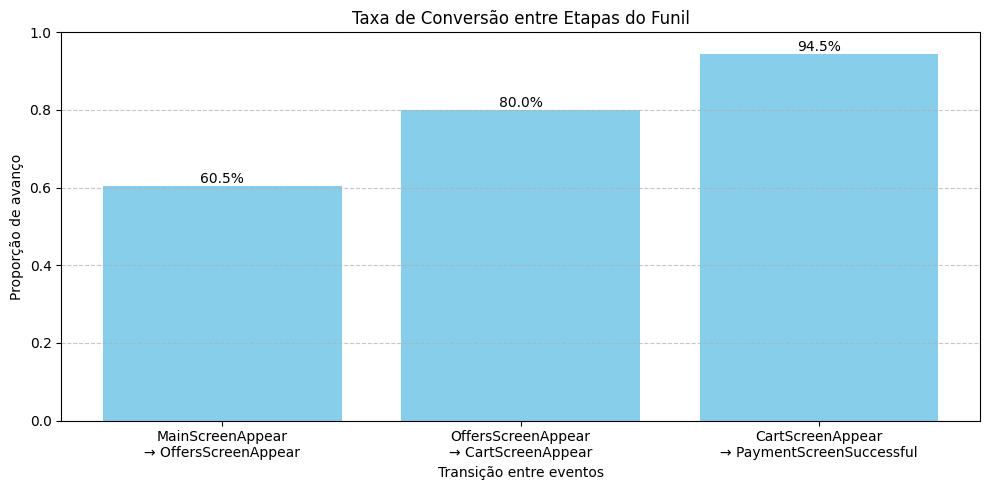

In [174]:
import matplotlib.pyplot as plt

# Lista para armazenar as proporções e rótulos
proporcoes = []
rotulos = []

for i in range(len(eventos_funnel) - 1):
    etapa_atual = eventos_funnel[i]
    proxima_etapa = eventos_funnel[i + 1]
    
    usuarios_atual = usuarios_por_evento[etapa_atual]
    usuarios_proxima = usuarios_por_evento[proxima_etapa]
    
    usuarios_que_avancaram = usuarios_atual & usuarios_proxima
    
    proporcao = len(usuarios_que_avancaram) / len(usuarios_atual) if len(usuarios_atual) > 0 else 0
    
    rotulo = f"{etapa_atual} → {proxima_etapa}"
    rotulos.append(rotulo)
    proporcoes.append(proporcao)
rotulos = [
    "MainScreenAppear\n→ OffersScreenAppear",
    "OffersScreenAppear\n→ CartScreenAppear",
    "CartScreenAppear\n→ PaymentScreenSuccessful"
]
# Plotando gráfico de barras
plt.figure(figsize=(10, 5))
bars = plt.bar(rotulos, proporcoes, color='skyblue')

# Adicionando os valores em cima das barras
for bar, prop in zip(bars, proporcoes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{prop:.1%}", 
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1)
plt.title('Taxa de Conversão entre Etapas do Funil')
plt.ylabel('Proporção de avanço')
plt.xlabel('Transição entre eventos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- O funil de usuários foi analisado corretamente. Como sugestão, aqui você poderia plotar um gráfico de funil com os dados acima.
</div>

# Qual fase perde mais usuários
Na primeira faze perde-se mais usuários, entra a tela principal para a tela de ofertas.

In [175]:
# Ordem esperada de eventos (o funil completo)
sequencia_esperada = [
    "MainScreenAppear",
    "OffersScreenAppear",
    "CartScreenAppear",
    "PaymentScreenSuccessful"
]

# Agrupar eventos por usuário em ordem cronológica
eventos_por_usuario = df.sort_values('time').groupby('id')['event'].apply(list)

# Verifica se a sequência esperada está contida nos eventos do usuário
def contem_toda_a_sequencia(eventos):
    i = 0
    for evento in eventos:
        if evento == sequencia_esperada[i]:
            i += 1
            if i == len(sequencia_esperada):
                return True
    return False

# Aplicar a função a todos os usuários
usuarios_com_caminho_completo = eventos_por_usuario.apply(contem_toda_a_sequencia)

# Número de usuários com o caminho completo
total_completo = usuarios_com_caminho_completo.sum()

# Total de usuários únicos
total_usuarios = df['id'].nunique()

# Proporção
proporcao = total_completo / total_usuarios

print(f"🧍 Usuários que fizeram o caminho inteiro: {total_completo}")
print(f"👥 Total de usuários únicos: {total_usuarios}")
print(f"📊 Proporção: {proporcao:.2%}")

# ================================
# NOVA PARTE: Analisar maior perda
# ================================

# Lista com a sequência dos eventos
eventos_funnel = [
    "MainScreenAppear",
    "OffersScreenAppear",
    "CartScreenAppear",
    "PaymentScreenSuccessful"
]

# Dicionário para armazenar os conjuntos de usuários de cada etapa
usuarios_por_evento = {}

# Obtemos o conjunto de usuários únicos por evento
for evento in eventos_funnel:
    usuarios_por_evento[evento] = set(df[df['event'] == evento]['id'].unique())

# Calcula as proporções de avanço entre etapas
proporcoes = []
transicoes = []

for i in range(len(eventos_funnel) - 1):
    etapa_atual = eventos_funnel[i]
    proxima_etapa = eventos_funnel[i + 1]
    
    usuarios_atual = usuarios_por_evento[etapa_atual]
    usuarios_proxima = usuarios_por_evento[proxima_etapa]
    
    usuarios_que_avancaram = usuarios_atual & usuarios_proxima
    
    proporcao_avanco = len(usuarios_que_avancaram) / len(usuarios_atual) if len(usuarios_atual) > 0 else 0
    
    proporcoes.append(proporcao_avanco)
    transicoes.append(f"{etapa_atual} → {proxima_etapa}")

# Identificar onde foi a maior perda
maior_perda_idx = proporcoes.index(min(proporcoes))
maior_perda_transicao = transicoes[maior_perda_idx]
perda_percentual = (1 - proporcoes[maior_perda_idx]) * 100

print(f"\n🚨 A maior perda de usuários ocorreu na transição: '{maior_perda_transicao}'")
print(f"❌ Percentual de perda: {perda_percentual:.2f}%")


🧍 Usuários que fizeram o caminho inteiro: 2974
👥 Total de usuários únicos: 7542
📊 Proporção: 39.43%

🚨 A maior perda de usuários ocorreu na transição: 'MainScreenAppear → OffersScreenAppear'
❌ Percentual de perda: 39.47%


<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
   
Aqui precisamos realizar a análise abaixo:
    
- [ ] A etapa do funil em que há maior perda de usuários foi calculada
- [x] O percentual de usuários que fizeram todas as etapas do funil foi analisado.
</div>

In [176]:
df.groupby('group')['id'].count()

C:\Users\jonat\AppData\Local\Temp\ipykernel_12488\1343537145.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('group')['id'].count()


group
A1    80045
A2    77811
B     85473
Name: id, dtype: int64

In [181]:
def testar_diferenca_proporcao_eventos(df, grupos, grupo_teste=None, alpha=0.1):
    # Total de usuários únicos por grupo
    totais = df[df['group'].isin(grupos + ([grupo_teste] if grupo_teste else []))].groupby('group')['id'].nunique()
    
    resultados = []
    eventos = df['event'].unique()

    for evento in eventos:
        linha = {'event': evento}
        
        # Coleta os dados para os grupos de controle
        k_ctrl = []
        p_ctrl = []
        for grupo in grupos:
            k = df[(df['group'] == grupo) & (df['event'] == evento)]['id'].nunique()
            p = k / totais[grupo]
            linha[f'{grupo}_users'] = k
            linha[f'{grupo}_%'] = f'{p:.2%}'
            k_ctrl.append(k)
            p_ctrl.append(p)
        
        # Se tiver grupo de teste (ex: B), compara com cada controle e com o conjunto dos dois
        if grupo_teste:
            k_t = df[(df['group'] == grupo_teste) & (df['event'] == evento)]['id'].nunique()
            p_t = k_t / totais[grupo_teste]
            linha[f'{grupo_teste}_users'] = k_t
            linha[f'{grupo_teste}_%'] = f'{p_t:.2%}'

            # Testa contra cada grupo de controle
            for i, grupo in enumerate(grupos):
                p_val = z_test_proporcao(k_ctrl[i], totais[grupo], k_t, totais[grupo_teste])
                linha[f'p_{grupo}_vs_{grupo_teste}'] = round(p_val, 3)

            # Teste combinado dos controles vs grupo_teste
            k_comb = sum(k_ctrl)
            n_comb = sum(totais[g] for g in grupos)
            p_val_comb = z_test_proporcao(k_comb, n_comb, k_t, totais[grupo_teste])
            linha[f'p_comb_vs_{grupo_teste}'] = round(p_val_comb, 3)

        resultados.append(linha)

    # Cria DataFrame de resultados
    tabela = pd.DataFrame(resultados).sort_values('event')

    # Verifica se todos os testes não rejeitam H0
    if grupo_teste:
        cols_p = [col for col in tabela.columns if col.startswith('p_')]
        mask_sem_diferenca = (tabela[cols_p] >= alpha).all(axis=1)
        if mask_sem_diferenca.all():
            print(f"\n✅ Todos os eventos têm p ≥ {alpha} em todas as comparações → nenhuma diferença significativa.")
        else:
            print(f"\n⚠️ Pelo menos um evento tem p < {alpha} → possível efeito do tratamento ou desequilíbrio.")
    else:
        p_cols = []
        for i in range(len(grupos)):
            for j in range(i+1, len(grupos)):
                g1, g2 = grupos[i], grupos[j]
                tabela[f'p_{g1}_vs_{g2}'] = [
                    round(z_test_proporcao(
                        df[(df['group']==g1) & (df['event']==evento)]['id'].nunique(), totais[g1],
                        df[(df['group']==g2) & (df['event']==evento)]['id'].nunique(), totais[g2]
                    ), 3) for evento in eventos
                ]
                p_cols.append(f'p_{g1}_vs_{g2}')
        if tabela[p_cols].ge(alpha).all(axis=None):
            print(f"\n✅ Todos os eventos têm p ≥ {alpha} entre {grupos} → grupos balanceados.")
        else:
            print(f"\n⚠️ Há diferença significativa (p < {alpha}) entre grupos de controle → A/A pode estar quebrado.")

    return tabela

# Função auxiliar
def z_test_proporcao(k1, n1, k2, n2):
    p_comb = (k1 + k2) / (n1 + n2)
    se = np.sqrt(p_comb * (1 - p_comb) * (1/n1 + 1/n2))
    z = (k1/n1 - k2/n2) / se
    return 2 * (1 - st.norm.cdf(abs(z)))


In [182]:
res_aa = testar_diferenca_proporcao_eventos(df, grupos=['A1', 'A2'], alpha=0.1)
print(res_aa)


C:\Users\jonat\AppData\Local\Temp\ipykernel_12488\1058588856.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totais = df[df['group'].isin(grupos + ([grupo_teste] if grupo_teste else []))].groupby('group')['id'].nunique()



✅ Todos os eventos têm p ≥ 0.1 entre ['A1', 'A2'] → grupos balanceados.
                     event  A1_users    A1_%  A2_users    A2_%  p_A1_vs_A2
4         CartScreenAppear      1267  50.99%      1239  49.23%       0.587
0         MainScreenAppear      2452  98.67%      2479  98.49%       0.274
1       OffersScreenAppear      1544  62.13%      1526  60.63%       0.879
3  PaymentScreenSuccessful      1200  48.29%      1159  46.05%       0.112
2                 Tutorial       278  11.19%       285  11.32%       0.213


In [183]:
res_ab = testar_diferenca_proporcao_eventos(df, grupos=['A1', 'A2'], grupo_teste='B', alpha=0.1)
print(res_ab)



⚠️ Pelo menos um evento tem p < 0.1 → possível efeito do tratamento ou desequilíbrio.
                     event  A1_users    A1_%  A2_users    A2_%  B_users  \
4         CartScreenAppear      1267  50.99%      1239  49.23%     1236   
0         MainScreenAppear      2452  98.67%      2479  98.49%     2498   
1       OffersScreenAppear      1544  62.13%      1526  60.63%     1536   
3  PaymentScreenSuccessful      1200  48.29%      1159  46.05%     1183   
2                 Tutorial       278  11.19%       285  11.32%      282   

      B_%  p_A1_vs_B  p_A2_vs_B  p_comb_vs_B  
4  48.66%      0.099      0.688        0.238  
0  98.35%      0.341      0.682        0.429  
1  60.47%      0.227      0.910        0.447  
3  46.57%      0.224      0.707        0.630  
2  11.10%      0.924      0.804        0.842  


C:\Users\jonat\AppData\Local\Temp\ipykernel_12488\1058588856.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totais = df[df['group'].isin(grupos + ([grupo_teste] if grupo_teste else []))].groupby('group')['id'].nunique()


In [186]:
# Se tiver 30 testes, ajusta alpha:
alpha_bonf = 0.1 / 30
res_bonf = testar_diferenca_proporcao_eventos(df, grupos=['A1', 'A2'], grupo_teste='B', alpha=alpha_bonf)
print(res_bonf)



✅ Todos os eventos têm p ≥ 0.0033333333333333335 em todas as comparações → nenhuma diferença significativa.
                     event  A1_users    A1_%  A2_users    A2_%  B_users  \
4         CartScreenAppear      1267  50.99%      1239  49.23%     1236   
0         MainScreenAppear      2452  98.67%      2479  98.49%     2498   
1       OffersScreenAppear      1544  62.13%      1526  60.63%     1536   
3  PaymentScreenSuccessful      1200  48.29%      1159  46.05%     1183   
2                 Tutorial       278  11.19%       285  11.32%      282   

      B_%  p_A1_vs_B  p_A2_vs_B  p_comb_vs_B  
4  48.66%      0.099      0.688        0.238  
0  98.35%      0.341      0.682        0.429  
1  60.47%      0.227      0.910        0.447  
3  46.57%      0.224      0.707        0.630  
2  11.10%      0.924      0.804        0.842  


C:\Users\jonat\AppData\Local\Temp\ipykernel_12488\1058588856.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totais = df[df['group'].isin(grupos + ([grupo_teste] if grupo_teste else []))].groupby('group')['id'].nunique()


Nenhum p-valor fica abaixo de 0.05, em nenhuma das três comparações para qualquer evento.

Isso significa que não há diferença estatisticamente significativa entre o grupo de fontes alteradas (B) e nenhum dos grupos de controle (A1, A2 ou A1 + A2) em termos da proporção de usuários que executaram cada evento.
# Conclusões do experimento

A randomização dos usuários parece ter funcionado corretamente: os três grupos são estatisticamente equivalentes para todas as ações medida

Em cada um dos comparativos (A1 vs A2, A1 vs B, A2 vs B e combinado vs B), foi utilizado um nível de significância de α = 0,1 para rejeição da hipótese nula (H₀). Esse valor indica que estamos aceitando até 10% de chance de cometer um erro tipo I em cada teste isolado.
Foram analisados 5 eventos, com 3 comparações realizadas em cada um (A1 vs B, A2 vs B e A1+A2 vs B), totalizando 15 testes estatísticos.

Isso significa que, com α = 0,1, existe uma chance de até 10% de rejeitar uma hipótese nula verdadeira em cada teste, o que aumenta a probabilidade de pelo menos um falso positivo ao realizar múltiplos testes.

Para controlar o erro global, uma alternativa é aplicar o ajuste de Bonferroni: α corrigido = 0,05 / 15 ≈ 0,0033 por teste. Outra possibilidade é usar o método de controle da FDR, como Benjamini-Hochberg, que é menos conservador e busca equilibrar descobertas verdadeiras com o risco de falsos positivos.

Caso decida aplicar um nível de significância ajustado (como 0,0033), será necessário refazer todos os testes e verificar se os p-valores permanecem abaixo do novo limiar. Isso indicará se ainda há diferenças estatisticamente significativas.

<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
Aqui você poderiia simplificar o teste de proporções. Segue um exemplo abaixo:
```python
    
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01):
    # proportion of successes in the first group:
    p1 = successes1/trials1

    # proportion of successes in the second group:
    p2 = successes2/trials2

    # proportion of successes in the combined dataset:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # the difference of proportions in datasets
    difference = p1 - p2
    
    # calculating the statistic in standard deviations of standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # setting standard normal distribution (mean= 0, standard deviation=1)
    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        ...
    else:
        ...
                         
                         
... # Usando a função acima (repita isso para outros eventos)
                         
check_hypothesis(users_events_per_group.loc['MainScreenAppear', 246],
                 users_events_per_group.loc['MainScreenAppear', 247],
                 users_per_group.loc[246],
                 users_per_group.loc[247],
                )   
```

</div>

## Conclusão

Após a análise detalhada dos logs de eventos do teste A/B, podemos tirar as seguintes conclusões:

1.  **Pré-processamento e Análise Exploratória:** Os dados foram carregados, limpos e preparados adequadamente. A análise exploratória revelou um funil de eventos claro (`MainScreenAppear` -> `OffersScreenAppear` -> `CartScreenAppear` -> `PaymentScreenSuccessful`), com a maior taxa de abandono ocorrendo na primeira transição. Cerca de 39% dos usuários que iniciaram o funil completaram o pagamento. Os dados mostraram maior consistência a partir de 31/07/2019, mas a análise utilizou o conjunto completo devido à perda mínima de dados ao filtrar.

2.  **Validação do Teste A/A:** A comparação entre os grupos de controle A1 e A2 (teste A/A) não mostrou diferenças estatisticamente significativas nas proporções de usuários para nenhum dos eventos analisados, utilizando o **nível de significância α = 0,1** definido para cada teste individual (todos os p-valores foram maiores que 0,1). Isso confirma que os grupos de controle eram homogêneos e que a divisão dos usuários foi feita corretamente, validando a configuração do experimento.

3.  **Resultados do Teste A/B:** A comparação do grupo de teste B (com a nova fonte) contra os grupos de controle A1, A2 e o combinado (A1+A2) também não revelou diferenças estatisticamente significativas em nenhuma das etapas do funil. Todos os p-valores calculados para as 15 comparações A/B foram **superiores ao nível de significância α = 0,1**.

4.  **Impacto da Mudança de Fonte:** Com base nos resultados dos testes estatísticos (utilizando um nível de significância **α = 0,1 por teste**), **não há evidências estatísticas para concluir que a alteração da fonte no aplicativo teve um impacto mensurável** na proporção de usuários que progridem através das principais etapas do funil de compra durante o período analisado. A mudança parece ser neutra em relação a essas métricas.

5.  **Considerações sobre Testes Múltiplos e Nível de Significância:** Foi utilizado um nível de significância de **α = 0,1** para cada teste individual. Foram realizados 15 testes estatísticos independentes nas comparações A/B (5 eventos x 3 comparações). Embora usar α = 0,1 aumente a chance de erro Tipo I (rejeitar H₀ quando ela é verdadeira) para 10% em cada teste, a realização de múltiplos testes eleva a probabilidade acumulada de ocorrer pelo menos um falso positivo (erro familiar). Métodos como a correção de Bonferroni (α corrigido ≈ 0,0033) ou o controle da Taxa de Falsas Descobertas (FDR) poderiam ser usados para mitigar esse risco. No entanto, como **nenhum dos p-valores individuais sequer se aproximou do limiar inicial de 0,1**, a aplicação dessas correções mais rigorosas não alteraria a conclusão principal. A ausência de significância estatística, mesmo sob um critério individual menos estrito (α = 0,1), reforça a conclusão de que a mudança de fonte provavelmente não teve um efeito detectável.

Portanto, o experimento indica fortemente que a alteração da fonte é neutra em relação ao comportamento do usuário no funil de compras principal, conforme medido pelas proporções de conversão entre etapas.